# Evaluation

For this evaluation exercise, we will be looking at the results extracted from `data/tables/soa_1.pdf`. 

In [1]:
from IPython.display import HTML
import json
from loguru import logger
import os, shutil

## 1. Helper Functions

In [2]:
def preprare_directory(temp, exist_ok=False):
    """
    Create a new directory and delete the old one if it exists
    :param temp: str: path to the directory
    """
    if os.path.exists(temp) and not exist_ok:
        # Remove the directory and all its contents
        shutil.rmtree(temp)
    # Recreate the directory
    os.makedirs(temp, exist_ok=exist_ok)

## 2. Tree Edit Distance Based Similarity (TEDS) Score

Tree Edit Distance based Similarity (TEDS) is a metric used to evaluate the quality of table structure extraction by measuring the similarity between predicted and ground truth HTML tables. 

TEDS scores range from `0.0`to `1.0`, where 1.0 indicates perfect similarity (identical tables) and 0.0 indicates no similarity (completely different tables). 

The score is calculated using the formula 

```
TEDS = 1.0 - (edit_distance / max_nodes)
```

where `edit_distance` represents the minimum number of operations (insertions, deletions, substitutions) needed to transform one table tree structure into another, and `max_nodes` is the maximum number of nodes in either table. 

TEDS considers both structural elements (rows, columns, cell spans) and cell content, making it particularly well-suited for evaluating table extraction systems. 

This metric is widely used in document analysis and table recognition research as it captures both the hierarchical structure and content accuracy of extracted tables.


### Dependencies

Install the required packages. 

In [3]:
# %pip install Levenshtein apted lxml

### Grount truth

We manually prepare a html file at `data/tables/soa_1_table_truth.html`. This is the ground truth data. We will load this

In [5]:
# when type is `tabular`, we need to display the HTML table
gt_fp = 'data/tables/soa_1_table_truth.html'
# gt_fp = 'data/tables-rotated/WO2024199665-table-rotated-truth.html'
# read the html file
with open(gt_fp, 'r') as f:
    gt_html = f.read()

# display the html file
display(HTML(gt_html))

### Prediction

We will load the Eclair extracted HTML from the `output_results/json_outputs/soa_1_page_1_fitz_resized_extracted.json`

In [7]:
pred_fp = 'output_results/json_outputs/soa_1_page_1_fitz_resized_extracted.json'
# pred_fp = 'output_results/json_outputs/WO2024199665-table-rotated_page_1_fitz_resized_extracted.json'
with open(pred_fp, 'r') as f:
    pred = json.load(f)
    # in Step 2 notebook, we see that the table is the 4th item in the content list
    pred_html = pred["content"][4]['data']['content_html']
    # pred_html = pred["content"][1]['data']['content_html']

display(HTML(pred_html))

### Calculate TEDS

We will use the script `teds.py`. The file requires 2 JSON files: 

```json
pred_json: {'FILENAME': 'HTML CODE', ...}
true_json: {'FILENAME': {'html': 'HTML CODE'}, ...}
```

In [10]:
from teds import TEDS

In [11]:
# format the pred_json and true_json
# IMPORTANT: TEDS code looks for 'body/table' xpath, but Eclair returns just the <table> HTML. 
# So we need to wrap it in <html><body> tags.
pred_html_wrapped = f'<html><body>{pred_html}</body></html>'
gt_html_wrapped = f'<html><body>{gt_html}</body></html>'

# The key ("soa_1", or whatever you want to call it) must match between pred_json and true_json
# Otherwise it will return a score of 0
pred_json = {
    "soa_1": pred_html_wrapped
}
true_json = {
    "soa_1": {"html": gt_html_wrapped}
}

# calculate the TEDS score
teds = TEDS(n_jobs=1)
eclair_scores = teds.batch_evaluate(pred_json, true_json)
print('Eclair (NeMo) TEDS scores:', eclair_scores)

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Eclair (NeMo) TEDS scores: {'soa_1': 0.9877461192468893}


The Eclair extracted table has a TEDS score of 0.99 (99% similarity). 

### Optional: Comparison Against Other Models

#### Preqrequistie

When comparing with other table extraction tools using TEDS, you must provide the extracted results in HTML format, wrapped directly with `<table>...</table>` tags. Do NOT include other tags

Extra attributes in the table tags are not necessary but won't affect TEDS. 

In in the demo below, please take a look at the example output files from GPT-5, Claude, etc we prepared.  All were all processed by retaining only the content between the `<table>..</table>` tags. Then we wrap it with `<html><body><table>...</table></body></html>` tags. This structure is required for TEDS script to work

#### GPT-5

We prepared an extraction results from GPT-5. The model was provided with the single-page PDF, with the prompt: 

```markdown
Extract the content of the table in HTML format. Make sure you accurately capture the table structure and information. 
```
Output HTML file was saved in `competitive/soa_1/soa_1_table_gpt-5.html`.

In [11]:
gpt5_fp = 'competitive/soa_1/soa_1_table_gpt-5.html'
with open(gpt5_fp, 'r') as f:
    gpt5_html = f.read()

display(HTML(gpt5_html))



In [12]:
# calculate the TEDS score
gpt5_html_wrapped = f'<html><body>{gpt5_html}</body></html>'
gpt5_json = {
    "soa_1": gpt5_html_wrapped
}
gpt5_scores = teds.batch_evaluate(gpt5_json, true_json)
print('GPT-5 TEDS scores:', gpt5_scores)




100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

GPT-5 TEDS scores: {'soa_1': 0.664319248826291}


#### Claude Sonnet 4

The same input file and prompt were used as in GPT-5

In [13]:
sonnet4_fp = 'competitive/soa_1/soa_1_table_sonnet_4.html'
with open(sonnet4_fp, 'r') as f:
    sonnet4_html = f.read()

display(HTML(sonnet4_html))

In [14]:
# format the pred_json and true_json
# IMPORTANT: TEDS code looks for 'body/table' xpath, but Eclair returns just the <table> HTML. 
# So we need to wrap it in <html><body> tags.
sonnet4_html_wrapped = f'<html><body>{sonnet4_html}</body></html>'
sonnet4_json = {
    "soa_1": sonnet4_html_wrapped
}
sonnet4_scores = teds.batch_evaluate(sonnet4_json, true_json)
print('Claude Sonnet 4 TEDS scores:', sonnet4_scores)



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

Claude Sonnet 4 TEDS scores: {'soa_1': 0.7229488039347194}


#### Gemini 2.5 Pro

Same input file and prompt as GPT-5

In [15]:
gemini_fp = 'competitive/soa_1/soa_1_table_gemini_pro_2.5.html'
with open(gemini_fp, 'r') as f:
    gemini_html = f.read()

display(HTML(gemini_html))
# format the pred_json and true_json


In [16]:
# calculate the TEDS score
gemini_html_wrapped = f'<html><body>{gemini_html}</body></html>'
gemini_json = {
    "soa_1": gemini_html_wrapped
}
gemini_scores = teds.batch_evaluate(gemini_json, true_json)
print('Gemini 2.5 Pro TEDS scores:', gemini_scores)

100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

Gemini 2.5 Pro TEDS scores: {'soa_1': 0.5151455681272454}


#### Unstructured.io

In [17]:
unstructured_fp = 'competitive/soa_1/soa_1_unstructured_io.html'
with open(unstructured_fp, 'r') as f:
    unstructured_html = f.read()

display(HTML(unstructured_html))

In [18]:
# calculate the TEDS score
unstructured_html_wrapped = f'<html><body>{unstructured_html}</body></html>'
unstructured_json = {
    "soa_1": unstructured_html_wrapped
}
unstructured_scores = teds.batch_evaluate(unstructured_json, true_json)
print('Unstructured.io TEDS scores:', unstructured_scores)

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Unstructured.io TEDS scores: {'soa_1': 0.6598188065139843}


#### PyMuPDF

The example below uses `find_table` from PyMuPDF to extract tables

In [23]:
import pymupdf
doc = pymupdf.open("data/tables/soa_1.pdf")
page = doc[0]
tabs = page.find_tables()  # detect the tables
table = tabs.tables[0].extract()
# replace None with empty string
table = [["" if cell is None else cell for cell in row] for row in table]

# convert to html
def table_to_html(table):
    html = "<table border='1'>\n"
    for row in table:
        html += "  <tr>" + "".join(f"<td>{cell}</td>" for cell in row) + "</tr>\n"
    html += "</table>"
    return html
pymupdf_html = table_to_html(table)

# save the html
with open('competitive/soa_1/soa_1_table_pymupdf.html', 'w') as f:
    f.write(pymupdf_html)

# display the html
HTML(pymupdf_html)

,Pre-Treatment Phase,,,,,,Treatment Phase1,,,,,,,,,,,,,,,,,,,,,,,,Post-Treatment Phase,,,,
,Cycle Number,,,Screening,,,Cycle 1,,,,,,,,,,,,"Cycle 2, 4, 6 etc.",,,,,,"Cycle 3, 5, 7 etc.",,,,,,EOT,,,1M FUP,
Day within Cycle Visit Window (± days),,,D-14 to D-1,,,D1,,,D8 (±2),,,D15 (±2),,,D22 (±2),,,D1,,,D15 (±2),,,D1,,,D15 (±2),,,≤ 10 d from the decision of trial treatment withdrawal,,,1 month after last dose of trial treatment (28+7d),,
Informed Consent,,,,X,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Baseline Characteristics/Eligibility2,,,,X,,,X,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,Safety Assessments,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Medication Survey,,,,X,,,X,,,X,,,X,,,X,,,X,,,X,,,X,,,X,,,X,,,X,
(S)AE Survey and Reporting,,,X,,,,X,,,X,,,X,,,X,,,X,,,X,,,X,,,X,,,X,,,X,
DLT Evaluation (dose-escalation only)3,,,,,,,X,,,X,,,X,,,X,,,C2/D1,,,,,,,,,,,,,,,,
Vital Signs and Body Weight,,,,X,,,X,,,,,,X,,,,,,X,,,X,,,X,,,X,,,X,,,X,
ECOG PS,,,,X,,,X,,,,,,,,,,,,X,,,,,,X,,,,,,X,,,X,


In [24]:
# calculate the TEDS score
pymupdf_html_wrapped = f'<html><body>{pymupdf_html}</body></html>'
pymupdf_json = {
    "soa_1": pymupdf_html_wrapped
}
pymupdf_scores = teds.batch_evaluate(pymupdf_json, true_json)
print('PyMuPDF TEDS scores:', pymupdf_scores)

100%|██████████| 1/1 [00:05<00:00,  5.17s/it]

PyMuPDF TEDS scores: {'soa_1': 0.33200499720492915}


#### Plot the scores

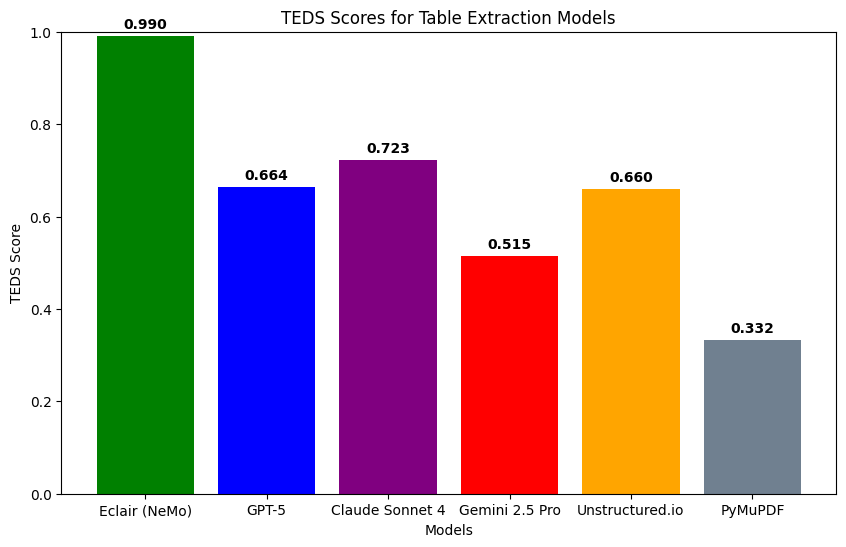

In [25]:
import matplotlib.pyplot as plt

# Create a bar plot for the TEDS scores
models = ['Eclair (NeMo)', 'GPT-5', 'Claude Sonnet 4', 'Gemini 2.5 Pro', 'Unstructured.io', 'PyMuPDF']
scores = [x['soa_1'] for x in [eclair_scores, gpt5_scores, sonnet4_scores, gemini_scores, unstructured_scores, pymupdf_scores]]

fig = plt.figure(figsize=(10, 6))
bars = plt.bar(models, scores, color=['green', 'blue', 'purple', 'red', 'orange', 'slategrey'])

# Add the numerical values on top of each bar
for i, (bar, score) in enumerate(zip(bars, scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Models')
plt.ylabel('TEDS Score')
plt.title('TEDS Scores for Table Extraction Models')
plt.ylim(0, 1.0)  # Set y-axis limit to give space for the text labels
plt.show()


In [19]:
# save the plot
output_dir = 'output_results/images/soa_1'
preprare_directory(output_dir)

fig.savefig(os.path.join(output_dir, 'teds_scores.png'))

## 3. Table Q&A Accuracy

In [20]:
import pandas as pd
import json
from loguru import logger

### Load Q&A table

We manually prepared 15 questions for table Q&A. First, we will load the Q&A benchmark dataset

In [21]:
df = pd.read_csv('data/tables/soa_1_table_qa.csv')
df.head()

,question,gt_answer,question_type,answer_type
0,The table contains merged columns. The top co...,3,check merged column structure,numeric
1,The table contains merged columns. The top co...,2,check merged column structure,numeric
2,The table contains merged columns. The top co...,2,check merged column structure,numeric
3,The table contains merged columns. The top co...,2,check merged column structure,numeric
4,The table contains merged columns. The top co...,4,check merged columns,numeric


In [22]:
# let's check the type of questions. These are 
df['question_type'].value_counts()

question_type
table lookup                     8
check merged column structure    4
table lookup with footnotes      2
check merged columns             1
Name: count, dtype: int64

In [23]:
# let's check the type of answers
# numeric: answer is a number
# binary: answer is Yes or No
# mcq: answer is a choice from a list of options: e.g. A, B, C, ...
df['answer_type'].value_counts()

answer_type
numeric    6
binary     6
mcq        3
Name: count, dtype: int64

### Prepare prompt template

Now we preapre instructions for the LLM on how to answer different types of questions. We will add this to the end of the question

In [29]:
instructions =  {
    'binary': 'You must respond with either "Answer: Yes" or "Answer: No". Do not include any other text.',
    "numeric": 'You must respond with "Answer: <number>". Do not include any other text.',
    "mcq": 'You must respond with "Answer: <a single letter representing your choice>". Do not include any other text.'
}

Next, let's prepare the prompt template

In [ ]:
prompt_template = """
### Instructions
You will be provided with a context and a question. 
The context contains text and HTML style table extracted from a clinical trial document, using a OCR model
The table shows schedule of assessment in a a clincial trials. 
Columns are phases and days, and rows are assessments/activites. 
If there is an X in the cell, it means that the assessment/activity is conducted or scheduled on that day. 
Otherwise, if cell is left blank, it means that the assessment/activity is not conducted or scheduled on that day.
During the extraction, some formatting might be off (e.g. superscripts, subscripts, etc.).

Your task is to answer the question based on information provided in the context. 
There might also be "noise"/"errors" during the table extraction process. 
Do your best to disern possible extraction errors, and provide an answer that is most likely to be correct.

### Context
{extracted_text}

### Question
{question}
{instructions}
"""

### Load extracted text and table

In [31]:
def load_extracted_text_and_table(json_fp, arbitrary_html=None):

    """
    Load the extracted text and table from the json file.
    Args: 
        json_fp: str, path to the json file
        arbitrary_html: str, optional, defaults to None. If provided, it will be used as the table html instead of the one in the json file
    Returns: 
        str, extracted text and table combined into a single string
    """

    # load the json file
    with open(json_fp, 'r') as f:
        json_data = json.load(f)
    
    # get the content list, and sort by ymin of the bounding box
    # this helps to keep the text and the table in the same order as they appear in the document
    # since the document is single-column
    logger.warning("Sorting the content by ymin of the bounding box. This works for single-column documents. For multi-column documents, proceed with caution")
    content = json_data['content']
    content.sort(key=lambda x: x['metadata']['bbox']['ymin'])

    # then concatenate the extracted context into a string
    extracted_text = ""
    for item in content:
        data = item['data']
        if data['type'] == 'textual':
            extracted_text += data['content'] + "\n"
        elif data['type'] == 'tabular':
            if not arbitrary_html:
                extracted_text += data['content_html']  
            else:
                extracted_text += arbitrary_html

    return extracted_text
    

In [48]:
# load the extraction result json file
json_fp = 'output_results/json_outputs/soa_1_page_1_fitz_extracted.json'
extracted_text = load_extracted_text_and_table(json_fp)

# take a look at the extracted text
print(extracted_text)

2025-09-22 10:30:36.636 | WARNING  | __main__:load_extracted_text_and_table:19 - Sorting the content by ymin of the bounding box. This works for single-column documents. For multi-column documents, proceed with caution


**Symphogen Trial ID: Sym004-09** **Clinical Trial Protocol Version 4.0**
Table 2 Flow Chart – Schedule of Assessments
<table>
  <tr>
    <td colspan="2"><b>Pre-Treatment Phase</b></td>
    <td colspan="8"><b>Treatment Phase1</b></td>
    <td colspan="3"><b>Post-Treatment Phase</b></td>
  </tr>
  <tr>
    <td><b>Cycle Number</b></td>
    <td><b>Screening</b></td>
    <td colspan="4"><b>Cycle 1</b></td>
    <td colspan="2"><b>Cycle 2, 4, 6 etc.</b></td>
    <td colspan="2"><b>Cycle 3, 5, 7 etc.</b></td>
    <td><b>EOT</b></td>
    <td><b>1M FUP</b></td>
  </tr>
  <tr>
    <td>Day within Cycle Visit Window (± days)</td>
    <td>D-14 to D-1</td>
    <td>D1</td>
    <td>D8 (±2)</td>
    <td>D15 (±2)</td>
    <td>D22 (±2)</td>
    <td>D1</td>
    <td>D15 (±2)</td>
    <td>D1</td>
    <td>D15 (±2)</td>
    <td>≤ 10 d from the decision of trial treatment withdrawal</td>
    <td>1 month after last dose of trial treatment (28+7d)</td>
  </tr>
  <tr>
    <td>Informed Consent</td>
    <td>X</td>


### Construct queries

In [49]:
queries = []
for index, row in df.iterrows():

    # get answer type
    answer_type = row['answer_type']
    # messages for the LLM
    messages = [
        {"role": "developer", "content": "You are a helpful assistant."},
    ]
    query = prompt_template.format(
        extracted_text=extracted_text, 
        question=row['question'], 
        instructions=instructions[answer_type]
    )
    messages.append({"role": "user", "content": query})
    queries.append({
        "query_idx": index,
        "messages": messages,
        "text_format": answer_type
    })

In [50]:
# take a look at an example query
print(json.dumps(queries[0], indent=4))

{
    "query_idx": 0,
    "messages": [
        {
            "role": "developer",
            "content": "You are a helpful assistant."
        },
        {
            "role": "user",
            "content": "\n### Instructions\nYou will be provided with a context and a question. \nThe context contains text and HTML style table extracted from a clinical trial document, using a OCR model\nThe table shows schedule of assessment in a a clincial trials. \nColumns are phases and days, and rows are assessments/activites. \nIf there is an X in the cell, it means that the assessment/activity is conducted or scheduled on that day. \nOtherwise, if cell is left blank, it means that the assessment/activity is not conducted or scheduled on that day.\nDuring the extraction, some formatting might be off (e.g. superscripts, subscripts, etc.).\n\nYour task is to answer the question based on information provided in the context. \nThere might also be \"noise\"/\"errors\" during the table extraction proc

### Set up LLM client 

Set up the client for the LLM that you will use for the Q&A. 

> For the Q&A part, we recommend using a reasoning model with high reasoning effort. Such models might have a better understanding of the parsed html code.  For example, when tested with the eclair extracted table, `gpt-4.1` scored 73%, while `gpt-5` scored 100%. 

In [45]:
import os
from pydantic import BaseModel
from openai import AsyncOpenAI
from typing import Literal

# pydantic schema for output
from pydantic import BaseModel, Field

class NumericAnswer(BaseModel):
    """
    A numeric answer and reasoning provided by the model.
    Useful when the response is expected to be a number.
    """
    Answer: float | int = Field(..., description="The numeric value of the answer.")
    Reasoning: str = Field(..., description="The reasoning for the answer.")

class BinaryAnswer(BaseModel):
    """
    A binary answer and reasoning provided by the model.
    Useful when the response is expected to be a Yes or No.
    """
    Answer: Literal["Yes", "No"] = Field(..., description="The binary value of the answer.")
    Reasoning: str = Field(..., description="The reasoning for the answer.")

class MCQAnswer(BaseModel):
    """
    A multiple choice answer and reasoning provided by the model.
    Useful when the response is expected to be one of the options.
    """
    # assuming max 4 options for multiple choice questions
    Answer: Literal['A', 'B', 'C', 'D'] = Field(..., description="The choice of the answer.")
    Reasoning: str = Field(..., description="The reasoning for the answer.")

# AsyncOpenAI client for async operations
client = AsyncOpenAI(
    api_key=os.getenv("LLM_GATEWAY_API"), 
    base_url= "https://prod.api.nvidia.com/llm/v1/azure/v1",
    default_query={"api-version": "preview"},
)

# model name, reasoning model recommended. 
model = "gpt-5"

### Run queries

In [46]:
import asyncio

async def process_query(query: dict):

    """
    Process a single query asynchronously
    Args:
        query (dict): A dictionary containing the query information
    Returns:
        dict: A dictionary containing the query index, answer, success, and error
    """
    query_format = query['text_format']
    query_idx = query['query_idx']

    # Get the appropriate text format based on the query type
    if query_format == 'numeric':
        text_format = NumericAnswer
    elif query_format == 'binary':
        text_format = BinaryAnswer
    elif query_format == 'mcq':
        text_format = MCQAnswer
    else:
        raise ValueError(f"Unknown question type: {query_format}")

    # Make async API call (assuming the client supports async - if not, see alternative below)
    try:
        response = await client.responses.parse(
            model=model,
            input=query['messages'],
            text_format=text_format,
              reasoning = {
                "effort": "high", # only for reasoning models
                "summary": "auto"
            }
        )

        # check if response.output_parsed exists and have Answer attribute
        answer = response.output_parsed.Answer
        logger.info(f"Query {query_idx} processed successfully")

        # return the results
        return {
            'query_idx': query_idx,
            'answer': answer,
            'reasoning': response.output_parsed.Reasoning,
            'success': True,
            'error': None
        }

    except Exception as e:
        logger.error(f"Query {query_idx} failed: {e}")
        return {
            'query_idx': query_idx,
            'answer': None,
            'reasoning': None,
            'success': False,
            'error': str(e)
        }

In [58]:
# collect the results
tasks = [process_query(q) for q in queries]
results = await asyncio.gather(*tasks)

2025-09-21 19:18:21.610 | INFO     | __main__:process_query:39 - Query 10 processed successfully
2025-09-21 19:18:21.802 | INFO     | __main__:process_query:39 - Query 11 processed successfully
2025-09-21 19:18:23.560 | INFO     | __main__:process_query:39 - Query 13 processed successfully
2025-09-21 19:18:28.938 | INFO     | __main__:process_query:39 - Query 8 processed successfully
2025-09-21 19:18:31.284 | INFO     | __main__:process_query:39 - Query 14 processed successfully
2025-09-21 19:18:31.747 | INFO     | __main__:process_query:39 - Query 12 processed successfully
2025-09-21 19:18:33.329 | INFO     | __main__:process_query:39 - Query 4 processed successfully
2025-09-21 19:18:33.804 | INFO     | __main__:process_query:39 - Query 6 processed successfully
2025-09-21 19:18:34.633 | INFO     | __main__:process_query:39 - Query 0 processed successfully
2025-09-21 19:18:46.389 | INFO     | __main__:process_query:39 - Query 3 processed successfully
2025-09-21 19:18:49.482 | INFO     

In [63]:
# dump to file
qa_acc_output_dir = 'output_results/qa_accuracy/soa_1'
preprare_directory(qa_acc_output_dir)
with open(os.path.join(qa_acc_output_dir, 'soa_1_qa_results_eclair.json'), 'w') as f:
    json.dump(results, f, indent=4)

### Calculate Accuracy

In [64]:
# format results into a dataframe
eclair_qa_df = pd.DataFrame(results).sort_values(by='query_idx')
# add a new column to the original dataframe
df['pred_eclair_answer'] = eclair_qa_df['answer']
df['pred_eclair_reasoning'] = eclair_qa_df['reasoning']
df

,question,gt_answer,question_type,answer_type,pred_eclair_answer,pred_eclair_reasoning
0,The table contains merged columns. The top co...,3,check merged column structure,numeric,3,"Under the level 1 column “Treatment Phase”, th..."
1,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,Under the level 1 column 'Post-Treatment Phase...
2,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,"The HTML shows <td colspan=""2""><b>Pre-Treatmen..."
3,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,"The level 2 column 'Cycle 2, 4, 6 etc.' has co..."
4,The table contains merged columns. The top co...,4,check merged columns,numeric,4,"The HTML shows <td colspan=""4""><b>Cycle 1</b><..."
5,"How many activites are conducted on D8, Cycle 1?",5,table lookup,numeric,5,X marks at D8 (Cycle 1) appear for: Medication...
6,Is physical exam scheduled in Pre-Treatment Ph...,Yes,table lookup,binary,Yes,The table shows an X for Physical Examination ...
7,Is any ADA sample collection activity schedule...,No,table lookup,binary,No,The ADA sample row shows collections at Cycle ...
8,Is urinalysis activity scheudled on D13 of Cyc...,Yes,table lookup,binary,Yes,Urinalysis is scheduled on Cycle 1 Day 15 (±2 ...
9,"1 month after the last dose of treatment, is t...",Yes,table lookup,binary,Yes,The ECOG PS row shows an X under the 1M FUP (o...


In [49]:
import numpy as np
def compute_qa_accuracy(df, gt_col, pred_col):

    """
    Compute the accuracy of the Q&A model.
    Args: 
        df: pd.DataFrame, dataframe containing the ground truth and predicted answers
        gt_col: str, name of the column containing the ground truth answers
        pred_col: str, name of the column containing the predicted answers
    Returns: 
        float, accuracy score
    """
    # compute accuracy score
    total = 0
    correct = 0
    for idx, row in df.iterrows():
        # numeric answers
        if row['answer_type'] == 'numeric':
            # handling Null values in case LLM did not return an answer
            if row[pred_col] is None: 
                pred = np.inf
            # Try to cast  to float
            else:
                pred = float(row[pred_col])
            true = float(row[gt_col])
        # non-numeric answers
        else:
            # If LLM did not return an answer, put None
            if row[pred_col] is None:
                pred = 'None'
            # try to cast to uppercase string
            else:
                pred = row[pred_col].upper()
            true = row[gt_col].upper()
        
        if pred == true:
            correct += 1
            logger.success(f"Query {idx} is correct")
        else:
            logger.error(f"Query {idx} is incorrect")
        total += 1
    
    return total, correct, correct / total

In [69]:
total, correct, acc = compute_qa_accuracy(df, 'gt_answer', 'pred_eclair_answer')
print(f"Accuracy of Eclair: {acc:.2f}")


2025-09-21 19:30:14.932 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 0 is correct
2025-09-21 19:30:14.933 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 1 is correct
2025-09-21 19:30:14.934 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 2 is correct
2025-09-21 19:30:14.934 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 3 is correct
2025-09-21 19:30:14.934 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 4 is correct
2025-09-21 19:30:14.935 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 5 is correct
2025-09-21 19:30:14.935 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 6 is correct
2025-09-21 19:30:14.935 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 7 is correct
2025-09-21 19:30:14.935 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 8 is correct
2025-09-21 19:30:14.936 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 9 is correct
2025-09-21 19:30:14.936 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 10 is correct
2025-09-2

Accuracy of Eclair: 1.00


> Caveat: Eclair did not parse the table perfectly, as reflected by the TEDS score. However, Q&A accuracy could still reach 100%. Unlike TEDS, which is an unbiased metric, Q&A accuracy depends on the dataset. In some cases, extraction errors occur but the LLM can still reason its way to the correct answer. In others, the Q&A benchmark may overlook or disproportionately emphasize areas where extraction fails.


### Optional: Comparison against other models

#### GPT-5

In [ ]:
# load the Q&A benchmark dataset
df = pd.read_csv('data/tables/soa_1_table_qa.csv')

# load the extraction result json file
gpt5_html_fp = 'competitive/soa_1/soa_1_table_gpt-5.html'
# read the html file containing GPT-5's table extraction result
with open(gpt5_html_fp, 'r') as f:
    gpt5_html = f.read()

# Now combine the extracted text for Eclair with GPT-5's table extraction result
# This allows us to run head to head comparison between Eclair and GPT-5's table extraction performance
json_fp = 'output_results/json_outputs/soa_1_page_1_fitz_extracted.json'
gpt5_extracted_text = load_extracted_text_and_table(
    json_fp = json_fp,
    arbitrary_html = gpt5_html
)


# collect the queries for GPT-5 extracted table
gpt5_queries = []
for index, row in df.iterrows():

    # get answer type
    answer_type = row['answer_type']
    # messages for the LLM
    messages = [
        {"role": "developer", "content": "You are a helpful assistant."},
    ]
    query = prompt_template.format(
        extracted_text=gpt5_extracted_text, 
        question=row['question'], 
        instructions=instructions[answer_type]
    )
    messages.append({"role": "user", "content": query})
    gpt5_queries.append({
        "query_idx": index,
        "messages": messages,
        "text_format": answer_type
    })

2025-09-21 19:50:43.311 | WARNING  | __main__:load_extracted_text_and_table:19 - Sorting the content by ymin of the bounding box. This works for single-column documents. For multi-column documents, proceed with caution


In [13]:
# collect the results
gpt5_tasks = [process_query(q) for q in gpt5_queries]
gpt5_results = await asyncio.gather(*gpt5_tasks)

2025-09-21 19:52:46.071 | INFO     | __main__:process_query:39 - Query 14 processed successfully
2025-09-21 19:52:47.780 | INFO     | __main__:process_query:39 - Query 11 processed successfully
2025-09-21 19:52:49.373 | INFO     | __main__:process_query:39 - Query 10 processed successfully
2025-09-21 19:52:52.186 | INFO     | __main__:process_query:39 - Query 13 processed successfully
2025-09-21 19:52:52.604 | INFO     | __main__:process_query:39 - Query 3 processed successfully
2025-09-21 19:52:54.459 | INFO     | __main__:process_query:39 - Query 9 processed successfully
2025-09-21 19:52:56.182 | INFO     | __main__:process_query:39 - Query 2 processed successfully
2025-09-21 19:52:56.219 | INFO     | __main__:process_query:39 - Query 12 processed successfully
2025-09-21 19:52:56.718 | INFO     | __main__:process_query:39 - Query 0 processed successfully
2025-09-21 19:52:57.469 | INFO     | __main__:process_query:39 - Query 7 processed successfully
2025-09-21 19:52:59.047 | INFO     

In [ ]:
# dump to file
qa_acc_output_dir = 'output_results/qa_accuracy/soa_1'
with open(os.path.join(qa_acc_output_dir, 'soa_1_gpt5_qa_results.json'), 'w') as f:
    json.dump(gpt5_results, f, indent=4)

# cosntruct gpt5 qa dataframe
gpt5_qa_df = pd.DataFrame(gpt5_results).sort_values(by='query_idx')

# add a new column to the original dataframe
df['pred_gpt5_answer'] = gpt5_qa_df['answer']
df['pred_gpt5_reasoning'] = gpt5_qa_df['reasoning']
df

,question,gt_answer,question_type,answer_type,pred_gpt5_answer,pred_gpt5_reasoning
0,The table contains merged columns. The top co...,3,check merged column structure,numeric,3,"Under the level 1 column ""Treatment Phase"" (co..."
1,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,The level 1 header 'Post-Treatment Phase' has ...
2,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,The top-level header 'Pre-Treatment Phase' has...
3,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,"The level 2 column 'Cycle 2, 4, 6 etc.' has co..."
4,The table contains merged columns. The top co...,4,check merged columns,numeric,4,Under the level 2 column 'Cycle 1' (colspan=4)...
5,"How many activites are conducted on D8, Cycle 1?",5,table lookup,numeric,5,Activities with X on Cycle 1 Day 8: Medication...
6,Is physical exam scheduled in Pre-Treatment Ph...,Yes,table lookup,binary,Yes,The Physical Examination row shows an 'X' unde...
7,Is any ADA sample collection activity schedule...,No,table lookup,binary,No,"ADA samples are scheduled at Screening, Cycle ..."
8,Is urinalysis activity scheudled on D13 of Cyc...,Yes,table lookup,binary,Yes,Urinalysis is scheduled on Cycle 1 Day 15 (±2 ...
9,"1 month after the last dose of treatment, is t...",Yes,table lookup,binary,No,The ECOG PS row shows no X in the 1M FUP colum...


In [16]:
total, correct, acc = compute_qa_accuracy(df, 'gt_answer', 'pred_gpt5_answer')
print(f"Accuracy of GPT-5: {acc:.2f}")

2025-09-21 19:54:10.444 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 0 is correct
2025-09-21 19:54:10.444 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 1 is correct
2025-09-21 19:54:10.445 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 2 is correct
2025-09-21 19:54:10.445 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 3 is correct
2025-09-21 19:54:10.445 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 4 is correct
2025-09-21 19:54:10.445 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 5 is correct
2025-09-21 19:54:10.446 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 6 is correct
2025-09-21 19:54:10.446 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 7 is correct
2025-09-21 19:54:10.446 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 8 is correct
2025-09-21 19:54:10.446 | ERROR    | __main__:compute_qa_accuracy:27 - Query 9 is incorrect
2025-09-21 19:54:10.447 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 10 is correct
2025-09

Accuracy of GPT-5: 0.87


#### Claude Sonnet 4

In [19]:
# load the Q&A benchmark dataset
df = pd.read_csv('data/tables/soa_1_table_qa.csv')

# load the extraction result json file
sonnet4_html_fp = 'competitive/soa_1/soa_1_table_sonnet_4.html'
# read the html file containing GPT-5's table extraction result
with open(sonnet4_html_fp, 'r') as f:
    sonnet4_html = f.read()

# Now combine the extracted text for Eclair with Sonnet 4's table extraction result
# This allows us to run head to head comparison between Eclair and Sonnet 4's table extraction performance
json_fp = 'output_results/json_outputs/soa_1_page_1_fitz_extracted.json'
sonnet4_extracted_text = load_extracted_text_and_table(
    json_fp = json_fp,
    arbitrary_html = sonnet4_html
)


# collect the queries
sonnet4_queries = []
for index, row in df.iterrows():

    # get answer type
    answer_type = row['answer_type']
    # messages for the LLM
    messages = [
        {"role": "developer", "content": "You are a helpful assistant."},
    ]
    query = prompt_template.format(
        extracted_text=sonnet4_extracted_text,  # change here
        question=row['question'], 
        instructions=instructions[answer_type]
    )
    messages.append({"role": "user", "content": query})
    sonnet4_queries.append({
        "query_idx": index,
        "messages": messages,
        "text_format": answer_type
    })


2025-09-21 20:00:06.723 | WARNING  | __main__:load_extracted_text_and_table:19 - Sorting the content by ymin of the bounding box. This works for single-column documents. For multi-column documents, proceed with caution


In [20]:
# collect the results
sonnet4_tasks = [process_query(q) for q in sonnet4_queries]
sonnet4_results = await asyncio.gather(*sonnet4_tasks)


2025-09-21 20:00:38.067 | INFO     | __main__:process_query:39 - Query 11 processed successfully
2025-09-21 20:00:39.775 | INFO     | __main__:process_query:39 - Query 10 processed successfully
2025-09-21 20:00:41.478 | INFO     | __main__:process_query:39 - Query 14 processed successfully
2025-09-21 20:00:44.862 | INFO     | __main__:process_query:39 - Query 6 processed successfully
2025-09-21 20:00:44.920 | INFO     | __main__:process_query:39 - Query 3 processed successfully
2025-09-21 20:00:45.984 | INFO     | __main__:process_query:39 - Query 9 processed successfully
2025-09-21 20:00:47.423 | INFO     | __main__:process_query:39 - Query 13 processed successfully
2025-09-21 20:00:49.570 | INFO     | __main__:process_query:39 - Query 4 processed successfully
2025-09-21 20:00:51.208 | INFO     | __main__:process_query:39 - Query 12 processed successfully
2025-09-21 20:00:52.203 | INFO     | __main__:process_query:39 - Query 8 processed successfully
2025-09-21 20:00:54.979 | INFO     

In [21]:
# dump to file
with open(os.path.join(qa_acc_output_dir, 'soa_1_sonnet4_qa_results.json'), 'w') as f:
    json.dump(sonnet4_results, f, indent=4)


# cosntruct dataframe
sonnet4_qa_df = pd.DataFrame(sonnet4_results).sort_values(by='query_idx')

# add a new column to the original dataframe
df['pred_sonnet4_answer'] = sonnet4_qa_df['answer']
df['pred_sonnet4_reasoning'] = sonnet4_qa_df['reasoning']
df

,question,gt_answer,question_type,answer_type,pred_sonnet4_answer,pred_sonnet4_reasoning
0,The table contains merged columns. The top co...,3,check merged column structure,numeric,3,"Under the level 1 column 'Treatment Phase', th..."
1,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,Under the level 1 column 'Post-Treatment Phase...
2,The table contains merged columns. The top co...,2,check merged column structure,numeric,1,Under the top-level 'Pre-Treatment Phase' head...
3,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,"The level 2 column ""Cycle 2, 4, 6 etc."" has co..."
4,The table contains merged columns. The top co...,4,check merged columns,numeric,4,Under the level 2 column 'Cycle 1' there are f...
5,"How many activites are conducted on D8, Cycle 1?",5,table lookup,numeric,7,Count of Xs in the D8 (Cycle 1) column excludi...
6,Is physical exam scheduled in Pre-Treatment Ph...,Yes,table lookup,binary,Yes,Physical Examination has an 'X' in the Screeni...
7,Is any ADA sample collection activity schedule...,No,table lookup,binary,No,"ADA samples are scheduled at Screening, Cycle ..."
8,Is urinalysis activity scheudled on D13 of Cyc...,Yes,table lookup,binary,Yes,Urinalysis is scheduled on Cycle 1 Day 15 (±2)...
9,"1 month after the last dose of treatment, is t...",Yes,table lookup,binary,No,"In the ECOG PS row, the 1M FUP column is blank..."


In [22]:
total, correct, acc = compute_qa_accuracy(df, 'gt_answer', 'pred_sonnet4_answer')
print(f"Accuracy of Claude Sonnet 4: {acc:.2f}")

2025-09-21 20:02:27.100 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 0 is correct
2025-09-21 20:02:27.101 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 1 is correct
2025-09-21 20:02:27.101 | ERROR    | __main__:compute_qa_accuracy:27 - Query 2 is incorrect
2025-09-21 20:02:27.101 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 3 is correct
2025-09-21 20:02:27.102 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 4 is correct
2025-09-21 20:02:27.102 | ERROR    | __main__:compute_qa_accuracy:27 - Query 5 is incorrect
2025-09-21 20:02:27.102 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 6 is correct
2025-09-21 20:02:27.102 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 7 is correct
2025-09-21 20:02:27.103 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 8 is correct
2025-09-21 20:02:27.103 | ERROR    | __main__:compute_qa_accuracy:27 - Query 9 is incorrect
2025-09-21 20:02:27.103 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 10 is correct
202

Accuracy of Claude Sonnet 4: 0.80


#### Gemini 2.5 Pro

In [ ]:
# load the Q&A benchmark dataset
df = pd.read_csv('data/tables/soa_1_table_qa.csv')

# load the extraction result json file
gemini_fp = 'competitive/soa_1/soa_1_table_gemini_pro_2.5.html'
# read the html file containing GPT-5's table extraction result
with open(gemini_fp, 'r') as f:
    gemini_html = f.read()

# Now combine the extracted text for Eclair with Gemini table extraction result
# This allows us to run head to head comparison between Eclair and Sonnet 4's table extraction performance
json_fp = 'output_results/json_outputs/soa_1_page_1_fitz_extracted.json'
gemini_extracted_text = load_extracted_text_and_table(
    json_fp = json_fp,
    arbitrary_html = gemini_html
)


# collect the queries
gemini_queries = []
for index, row in df.iterrows():

    # get answer type
    answer_type = row['answer_type']
    # messages for the LLM
    messages = [
        {"role": "developer", "content": "You are a helpful assistant."},
    ]
    query = prompt_template.format(
        extracted_text=gemini_extracted_text,  # change here
        question=row['question'], 
        instructions=instructions[answer_type]
    )
    messages.append({"role": "user", "content": query})
    gemini_queries.append({
        "query_idx": index,
        "messages": messages,
        "text_format": answer_type
    })

2025-09-21 20:46:49.844 | WARNING  | __main__:load_extracted_text_and_table:19 - Sorting the content by ymin of the bounding box. This works for single-column documents. For multi-column documents, proceed with caution


In [9]:
# collect the results
gemini_tasks = [process_query(q) for q in gemini_queries]
gemini_results = await asyncio.gather(*gemini_tasks)

2025-09-21 20:47:04.102 | INFO     | __main__:process_query:39 - Query 14 processed successfully
2025-09-21 20:47:04.497 | INFO     | __main__:process_query:39 - Query 11 processed successfully
2025-09-21 20:47:04.600 | INFO     | __main__:process_query:39 - Query 13 processed successfully
2025-09-21 20:47:05.803 | INFO     | __main__:process_query:39 - Query 6 processed successfully
2025-09-21 20:47:09.276 | INFO     | __main__:process_query:39 - Query 1 processed successfully
2025-09-21 20:47:11.956 | INFO     | __main__:process_query:39 - Query 8 processed successfully
2025-09-21 20:47:12.659 | INFO     | __main__:process_query:39 - Query 0 processed successfully
2025-09-21 20:47:15.856 | INFO     | __main__:process_query:39 - Query 9 processed successfully
2025-09-21 20:47:15.958 | INFO     | __main__:process_query:39 - Query 4 processed successfully
2025-09-21 20:47:17.394 | INFO     | __main__:process_query:39 - Query 2 processed successfully
2025-09-21 20:47:17.730 | INFO     | 

In [10]:
# dump to file
qa_acc_output_dir = 'output_results/qa_accuracy/soa_1'
with open(os.path.join(qa_acc_output_dir, 'soa_1_gemini_qa_results.json'), 'w') as f:
    json.dump(gemini_results, f, indent=4)


# cosntruct dataframe
gemini_qa_df = pd.DataFrame(gemini_results).sort_values(by='query_idx')

# add a new column to the original dataframe
df['pred_gemini_answer'] = gemini_qa_df['answer']
df['pred_gemini_reasoning'] = gemini_qa_df['reasoning']
df

,question,gt_answer,question_type,answer_type,pred_gemini_answer,pred_gemini_reasoning
0,The table contains merged columns. The top co...,3,check merged column structure,numeric,4,"Under the level 1 column 'Treatment Phase', th..."
1,The table contains merged columns. The top co...,2,check merged column structure,numeric,1,"Post-Treatment Phase has colspan=1, so it has ..."
2,The table contains merged columns. The top co...,2,check merged column structure,numeric,1,Under the level 1 column 'Pre-Treatment Phase'...
3,The table contains merged columns. The top co...,2,check merged column structure,numeric,0,"In the header, ""Cycle 2, 4, 6 etc."" on level 2..."
4,The table contains merged columns. The top co...,4,check merged columns,numeric,4,"Cycle 1 has colspan=""4"" and shows D1, D8 (+2),..."
5,"How many activites are conducted on D8, Cycle 1?",5,table lookup,numeric,5,"On Cycle 1 Day 8, the following rows have an X..."
6,Is physical exam scheduled in Pre-Treatment Ph...,Yes,table lookup,binary,Yes,Physical Examination has an X in the Pre-Treat...
7,Is any ADA sample collection activity schedule...,No,table lookup,binary,No,"ADA samples are scheduled at Screening, odd-nu..."
8,Is urinalysis activity scheudled on D13 of Cyc...,Yes,table lookup,binary,No,Urinalysis is scheduled on Cycle 1 Day 15 (not...
9,"1 month after the last dose of treatment, is t...",Yes,table lookup,binary,No,"The ECOG PS row has entries at Screening, Cycl..."


In [11]:
total, correct, acc = compute_qa_accuracy(df, 'gt_answer', 'pred_gemini_answer')
print(f"Accuracy of Gemini 2.5 Pro: {acc:.2f}")

2025-09-21 20:48:30.102 | ERROR    | __main__:compute_qa_accuracy:27 - Query 0 is incorrect
2025-09-21 20:48:30.103 | ERROR    | __main__:compute_qa_accuracy:27 - Query 1 is incorrect
2025-09-21 20:48:30.104 | ERROR    | __main__:compute_qa_accuracy:27 - Query 2 is incorrect
2025-09-21 20:48:30.104 | ERROR    | __main__:compute_qa_accuracy:27 - Query 3 is incorrect
2025-09-21 20:48:30.104 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 4 is correct
2025-09-21 20:48:30.105 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 5 is correct
2025-09-21 20:48:30.105 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 6 is correct
2025-09-21 20:48:30.105 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 7 is correct
2025-09-21 20:48:30.105 | ERROR    | __main__:compute_qa_accuracy:27 - Query 8 is incorrect
2025-09-21 20:48:30.105 | ERROR    | __main__:compute_qa_accuracy:27 - Query 9 is incorrect
2025-09-21 20:48:30.106 | ERROR    | __main__:compute_qa_accuracy:27 - Query 10 is incor

Accuracy of Gemini 2.5 Pro: 0.53


#### Unstructured.io

In [13]:
# load the Q&A benchmark dataset
df = pd.read_csv('data/tables/soa_1_table_qa.csv')

# load the extraction result json file
unstructured_fp = 'competitive/soa_1/soa_1_unstructured_io.html'
# read the html file containing GPT-5's table extraction result
with open(unstructured_fp, 'r') as f:
    unstructured_html = f.read()

# Now combine the extracted text for Eclair with Unstructured.io table extraction result
# This allows us to run head to head comparison between Eclair and Sonnet 4's table extraction performance
json_fp = 'output_results/json_outputs/soa_1_page_1_fitz_extracted.json'
unstructured_extracted_text = load_extracted_text_and_table(
    json_fp = json_fp,
    arbitrary_html = unstructured_html
)


# collect the queries
unstructured_queries = []
for index, row in df.iterrows():

    # get answer type
    answer_type = row['answer_type']
    # messages for the LLM
    messages = [
        {"role": "developer", "content": "You are a helpful assistant."},
    ]
    query = prompt_template.format(
        extracted_text=unstructured_extracted_text,  # change here
        question=row['question'], 
        instructions=instructions[answer_type]
    )
    messages.append({"role": "user", "content": query})
    unstructured_queries.append({
        "query_idx": index,
        "messages": messages,
        "text_format": answer_type
    })

2025-09-21 20:51:25.427 | WARNING  | __main__:load_extracted_text_and_table:19 - Sorting the content by ymin of the bounding box. This works for single-column documents. For multi-column documents, proceed with caution


In [14]:
# collect the results
unstructured_tasks = [process_query(q) for q in unstructured_queries]
unstructured_results = await asyncio.gather(*unstructured_tasks)

2025-09-21 20:51:53.261 | INFO     | __main__:process_query:39 - Query 9 processed successfully
2025-09-21 20:51:53.870 | INFO     | __main__:process_query:39 - Query 10 processed successfully
2025-09-21 20:51:54.177 | INFO     | __main__:process_query:39 - Query 12 processed successfully
2025-09-21 20:51:54.692 | INFO     | __main__:process_query:39 - Query 14 processed successfully
2025-09-21 20:51:55.407 | INFO     | __main__:process_query:39 - Query 11 processed successfully
2025-09-21 20:51:55.952 | INFO     | __main__:process_query:39 - Query 6 processed successfully
2025-09-21 20:51:58.069 | INFO     | __main__:process_query:39 - Query 0 processed successfully
2025-09-21 20:51:58.378 | INFO     | __main__:process_query:39 - Query 13 processed successfully
2025-09-21 20:51:59.607 | INFO     | __main__:process_query:39 - Query 7 processed successfully
2025-09-21 20:52:00.914 | INFO     | __main__:process_query:39 - Query 2 processed successfully
2025-09-21 20:52:03.357 | INFO     

In [15]:
# dump to file
qa_acc_output_dir = 'output_results/qa_accuracy/soa_1'
with open(os.path.join(qa_acc_output_dir, 'soa_1_unstructured_qa_results.json'), 'w') as f:
    json.dump(unstructured_results, f, indent=4)


# cosntruct dataframe
unstructured_qa_df = pd.DataFrame(unstructured_results).sort_values(by='query_idx')

# add a new column to the original dataframe
df['pred_unstructured_answer'] = unstructured_qa_df['answer']
df['pred_unstructured_reasoning'] = unstructured_qa_df['reasoning']
df

,question,gt_answer,question_type,answer_type,pred_unstructured_answer,pred_unstructured_reasoning
0,The table contains merged columns. The top co...,3,check merged column structure,numeric,1,"Under the level 1 column 'Treatment Phase¹', t..."
1,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,The level 1 header 'Post-Treatment Phase' has ...
2,The table contains merged columns. The top co...,2,check merged column structure,numeric,1,Under the level 1 column 'Pre-Treatment Phase'...
3,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,Typical schedule shows D1 and D15 for even-num...
4,The table contains merged columns. The top co...,4,check merged columns,numeric,4,Under the level 2 column 'Cycle 1' (colspan=4)...
5,"How many activites are conducted on D8, Cycle 1?",5,table lookup,numeric,5,"D8 Cycle 1 has X for: Medication Survey, (S)AE..."
6,Is physical exam scheduled in Pre-Treatment Ph...,Yes,table lookup,binary,Yes,The table shows an 'X' for Physical Examinatio...
7,Is any ADA sample collection activity schedule...,No,table lookup,binary,No,The table shows ADA sample collection only on ...
8,Is urinalysis activity scheudled on D13 of Cyc...,Yes,table lookup,binary,Yes,Urinalysis is scheduled on Cycle 1 Day 15 with...
9,"1 month after the last dose of treatment, is t...",Yes,table lookup,binary,Yes,The ECOG PS row shows an X in the 1M FUP colum...


In [16]:
total, correct, acc = compute_qa_accuracy(df, 'gt_answer', 'pred_unstructured_answer')
print(f"Accuracy of Unstructured.io: {acc:.2f}")

2025-09-21 20:52:56.694 | ERROR    | __main__:compute_qa_accuracy:27 - Query 0 is incorrect
2025-09-21 20:52:56.694 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 1 is correct
2025-09-21 20:52:56.695 | ERROR    | __main__:compute_qa_accuracy:27 - Query 2 is incorrect
2025-09-21 20:52:56.695 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 3 is correct
2025-09-21 20:52:56.695 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 4 is correct
2025-09-21 20:52:56.695 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 5 is correct
2025-09-21 20:52:56.695 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 6 is correct
2025-09-21 20:52:56.696 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 7 is correct
2025-09-21 20:52:56.696 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 8 is correct
2025-09-21 20:52:56.696 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 9 is correct
2025-09-21 20:52:56.696 | SUCCESS  | __main__:compute_qa_accuracy:25 - Query 10 is correct
2025-

Accuracy of Unstructured.io: 0.80


#### PyMuPDF

In [47]:
# load the Q&A benchmark dataset
df = pd.read_csv('data/tables/soa_1_table_qa.csv')

# load the extraction result json file
pymupdf_fp = 'competitive/soa_1/soa_1_table_pymupdf.html'
# read the html file containing GPT-5's table extraction result
with open(pymupdf_fp, 'r') as f:
    pymupdf_html = f.read()

# Now combine the extracted text for Eclair with PyMuPDF table extraction result
# This allows us to run head to head comparison between Eclair and Sonnet 4's table extraction performance
json_fp = 'output_results/json_outputs/soa_1_page_1_fitz_extracted.json'
pymupdf_extracted_text = load_extracted_text_and_table(
    json_fp = json_fp,
    arbitrary_html = pymupdf_html
)


# collect the queries
pymupdf_queries = []
for index, row in df.iterrows():

    # get answer type
    answer_type = row['answer_type']
    # messages for the LLM
    messages = [
        {"role": "developer", "content": "You are a helpful assistant."},
    ]
    query = prompt_template.format(
        extracted_text=pymupdf_extracted_text,  # change here
        question=row['question'], 
        instructions=instructions[answer_type]
    )
    messages.append({"role": "user", "content": query})
    pymupdf_queries.append({
        "query_idx": index,
        "messages": messages,
        "text_format": answer_type
    })

2025-09-22 11:31:23.969 | WARNING  | __main__:load_extracted_text_and_table:19 - Sorting the content by ymin of the bounding box. This works for single-column documents. For multi-column documents, proceed with caution


In [48]:
# collect the results
pymupdf_tasks = [process_query(q) for q in pymupdf_queries]
pymupdf_results = await asyncio.gather(*pymupdf_tasks)

2025-09-22 11:31:49.551 | INFO     | __main__:process_query:39 - Query 10 processed successfully
2025-09-22 11:31:52.116 | INFO     | __main__:process_query:39 - Query 2 processed successfully
2025-09-22 11:31:52.502 | INFO     | __main__:process_query:39 - Query 11 processed successfully
2025-09-22 11:32:02.778 | INFO     | __main__:process_query:39 - Query 14 processed successfully
2025-09-22 11:32:10.342 | INFO     | __main__:process_query:39 - Query 6 processed successfully
2025-09-22 11:32:13.109 | INFO     | __main__:process_query:39 - Query 3 processed successfully
2025-09-22 11:32:29.354 | INFO     | __main__:process_query:39 - Query 4 processed successfully
2025-09-22 11:32:38.050 | INFO     | __main__:process_query:39 - Query 9 processed successfully
2025-09-22 11:32:44.799 | INFO     | __main__:process_query:39 - Query 13 processed successfully
2025-09-22 11:32:54.789 | INFO     | __main__:process_query:39 - Query 12 processed successfully
2025-09-22 11:32:55.544 | INFO     

In [50]:
# dump to file
qa_acc_output_dir = 'output_results/qa_accuracy/soa_1'
with open(os.path.join(qa_acc_output_dir, 'soa_1_pymupdf_qa_results.json'), 'w') as f:
    json.dump(pymupdf_results, f, indent=4)


# cosntruct dataframe
pymupdf_qa_df = pd.DataFrame(pymupdf_results).sort_values(by='query_idx')

# add a new column to the original dataframe
df['pred_pymupdf_answer'] = pymupdf_qa_df['answer']
df['pred_pymupdf_reasoning'] = pymupdf_qa_df['reasoning']
df

,question,gt_answer,question_type,answer_type,pred_pymupdf_answer,pred_pymupdf_reasoning
0,The table contains merged columns. The top co...,3,check merged column structure,numeric,3,"Under the level 1 column 'Treatment Phase', th..."
1,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,Post-Treatment Phase has two level 2 columns: ...
2,The table contains merged columns. The top co...,2,check merged column structure,numeric,1,"Under the level 1 column ""Pre-Treatment Phase""..."
3,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,"Under the level 2 column ""Cycle 2, 4, 6 etc."",..."
4,The table contains merged columns. The top co...,4,check merged columns,numeric,4,"Under the level 2 column ""Cycle 1"", the level ..."
5,"How many activites are conducted on D8, Cycle 1?",5,table lookup,numeric,None,None
6,Is physical exam scheduled in Pre-Treatment Ph...,Yes,table lookup,binary,Yes,The Physical Examination row has an X under th...
7,Is any ADA sample collection activity schedule...,No,table lookup,binary,No,"ADA samples are only scheduled at C1D1, C3D1, ..."
8,Is urinalysis activity scheudled on D13 of Cyc...,Yes,table lookup,binary,Yes,Urinalysis is scheduled on Cycle 1 Day 15 with...
9,"1 month after the last dose of treatment, is t...",Yes,table lookup,binary,Yes,The ECOG PS row shows an X in the 1M FUP colum...


In [51]:
total, correct, acc = compute_qa_accuracy(df, 'gt_answer', 'pred_pymupdf_answer')
print(f"Accuracy of PyMuPDF: {acc:.2f}")

2025-09-22 11:37:58.466 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 0 is correct
2025-09-22 11:37:58.466 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 1 is correct
2025-09-22 11:37:58.467 | ERROR    | __main__:compute_qa_accuracy:40 - Query 2 is incorrect
2025-09-22 11:37:58.467 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 3 is correct
2025-09-22 11:37:58.468 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 4 is correct
2025-09-22 11:37:58.468 | ERROR    | __main__:compute_qa_accuracy:40 - Query 5 is incorrect
2025-09-22 11:37:58.470 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 6 is correct
2025-09-22 11:37:58.472 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 7 is correct
2025-09-22 11:37:58.472 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 8 is correct
2025-09-22 11:37:58.473 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 9 is correct
2025-09-22 11:37:58.473 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 10 is correct
2025-

Accuracy of PyMuPDF: 0.87


#### Plot the scores

In [52]:
eclair_result_fp = 'output_results/qa_accuracy/soa_1/soa_1_qa_results_eclair.json'
gpt5_result_fp = 'output_results/qa_accuracy/soa_1/soa_1_gpt5_qa_results.json'
sonnet4_result_fp = 'output_results/qa_accuracy/soa_1/soa_1_sonnet4_qa_results.json'
gemini_result_fp = 'output_results/qa_accuracy/soa_1/soa_1_gemini_qa_results.json'
unstructured_result_fp = 'output_results/qa_accuracy/soa_1/soa_1_unstructured_qa_results.json'
pymupdf_result_fp = 'output_results/qa_accuracy/soa_1/soa_1_pymupdf_qa_results.json'


# load json files, and combine into a single dataframe
eclair_results = json.load(open(eclair_result_fp, 'r'))
gpt5_results = json.load(open(gpt5_result_fp, 'r'))
sonnet4_results = json.load(open(sonnet4_result_fp, 'r'))
gemini_results = json.load(open(gemini_result_fp, 'r'))
unstructured_results = json.load(open(unstructured_result_fp, 'r'))
pymupdf_results = json.load(open(pymupdf_result_fp, 'r'))

# convert to dataframes
eclair_qa_df = pd.DataFrame(eclair_results).sort_values(by='query_idx')
gpt5_qa_df = pd.DataFrame(gpt5_results).sort_values(by='query_idx')
sonnet4_qa_df = pd.DataFrame(sonnet4_results).sort_values(by='query_idx')
gemini_qa_df = pd.DataFrame(gemini_results).sort_values(by='query_idx')
unstructured_qa_df = pd.DataFrame(unstructured_results).sort_values(by='query_idx')
pymupdf_qa_df = pd.DataFrame(pymupdf_results).sort_values(by='query_idx')

# load the original dataframe
df = pd.read_csv('data/tables/soa_1_table_qa.csv')

# add the new columns to the original dataframe
df['pred_eclair_answer'] = eclair_qa_df['answer']
df['pred_eclair_reasoning'] = eclair_qa_df['reasoning']
df['pred_gpt5_answer'] = gpt5_qa_df['answer']
df['pred_gpt5_reasoning'] = gpt5_qa_df['reasoning']
df['pred_sonnet4_answer'] = sonnet4_qa_df['answer']
df['pred_sonnet4_reasoning'] = sonnet4_qa_df['reasoning']
df['pred_gemini_answer'] = gemini_qa_df['answer']
df['pred_gemini_reasoning'] = gemini_qa_df['reasoning']
df['pred_unstructured_answer'] = unstructured_qa_df['answer']
df['pred_unstructured_reasoning'] = unstructured_qa_df['reasoning']
df['pred_pymupdf_answer'] = pymupdf_qa_df['answer']
df['pred_pymupdf_reasoning'] = pymupdf_qa_df['reasoning']

df.head()


,question,gt_answer,question_type,answer_type,pred_eclair_answer,pred_eclair_reasoning,pred_gpt5_answer,pred_gpt5_reasoning,pred_sonnet4_answer,pred_sonnet4_reasoning,pred_gemini_answer,pred_gemini_reasoning,pred_unstructured_answer,pred_unstructured_reasoning,pred_pymupdf_answer,pred_pymupdf_reasoning
0,The table contains merged columns. The top co...,3,check merged column structure,numeric,3,"Under the level 1 column “Treatment Phase”, th...",3,"Under the level 1 column ""Treatment Phase"" (co...",3,"Under the level 1 column 'Treatment Phase', th...",4,"Under the level 1 column 'Treatment Phase', th...",1,"Under the level 1 column 'Treatment Phase¹', t...",3,"Under the level 1 column 'Treatment Phase', th..."
1,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,Under the level 1 column 'Post-Treatment Phase...,2,The level 1 header 'Post-Treatment Phase' has ...,2,Under the level 1 column 'Post-Treatment Phase...,1,"Post-Treatment Phase has colspan=1, so it has ...",2,The level 1 header 'Post-Treatment Phase' has ...,2,Post-Treatment Phase has two level 2 columns: ...
2,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,"The HTML shows <td colspan=""2""><b>Pre-Treatmen...",2,The top-level header 'Pre-Treatment Phase' has...,1,Under the top-level 'Pre-Treatment Phase' head...,1,Under the level 1 column 'Pre-Treatment Phase'...,1,Under the level 1 column 'Pre-Treatment Phase'...,1,"Under the level 1 column ""Pre-Treatment Phase""..."
3,The table contains merged columns. The top co...,2,check merged column structure,numeric,2,"The level 2 column 'Cycle 2, 4, 6 etc.' has co...",2,"The level 2 column 'Cycle 2, 4, 6 etc.' has co...",2,"The level 2 column ""Cycle 2, 4, 6 etc."" has co...",0,"In the header, ""Cycle 2, 4, 6 etc."" on level 2...",2,Typical schedule shows D1 and D15 for even-num...,2,"Under the level 2 column ""Cycle 2, 4, 6 etc."",..."
4,The table contains merged columns. The top co...,4,check merged columns,numeric,4,"The HTML shows <td colspan=""4""><b>Cycle 1</b><...",4,Under the level 2 column 'Cycle 1' (colspan=4)...,4,Under the level 2 column 'Cycle 1' there are f...,4,"Cycle 1 has colspan=""4"" and shows D1, D8 (+2),...",4,Under the level 2 column 'Cycle 1' (colspan=4)...,4,"Under the level 2 column ""Cycle 1"", the level ..."


In [53]:
# calculate the accuracy of the predictions
_, _, eclair_acc = compute_qa_accuracy(df, 'gt_answer', 'pred_eclair_answer')
_, _, gpt5_acc = compute_qa_accuracy(df, 'gt_answer', 'pred_gpt5_answer')
_, _, sonnet4_acc = compute_qa_accuracy(df, 'gt_answer', 'pred_sonnet4_answer')
_, _, gemini_acc = compute_qa_accuracy(df, 'gt_answer', 'pred_gemini_answer')
_, _, unstructured_acc = compute_qa_accuracy(df, 'gt_answer', 'pred_unstructured_answer')
_, _, pymupdf_acc = compute_qa_accuracy(df, 'gt_answer', 'pred_pymupdf_answer')

2025-09-22 11:38:03.813 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 0 is correct
2025-09-22 11:38:03.813 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 1 is correct
2025-09-22 11:38:03.814 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 2 is correct
2025-09-22 11:38:03.814 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 3 is correct
2025-09-22 11:38:03.814 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 4 is correct
2025-09-22 11:38:03.815 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 5 is correct
2025-09-22 11:38:03.815 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 6 is correct
2025-09-22 11:38:03.815 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 7 is correct
2025-09-22 11:38:03.815 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 8 is correct
2025-09-22 11:38:03.816 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 9 is correct
2025-09-22 11:38:03.816 | SUCCESS  | __main__:compute_qa_accuracy:38 - Query 10 is correct
2025-09-2

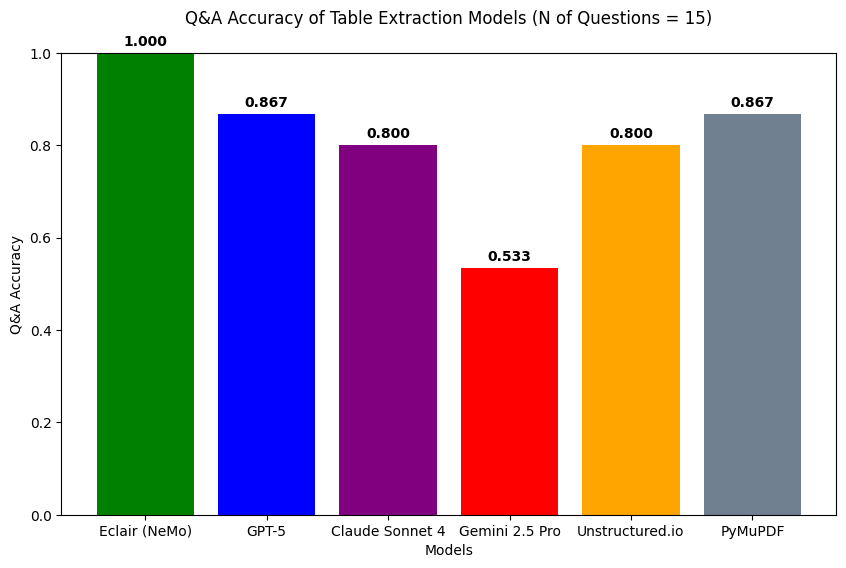

In [54]:
import matplotlib.pyplot as plt

# Create a bar plot for the Q&A Accuracy
models = ['Eclair (NeMo)', 'GPT-5', 'Claude Sonnet 4', 'Gemini 2.5 Pro', 'Unstructured.io', 'PyMuPDF']
scores = [eclair_acc, gpt5_acc, sonnet4_acc, gemini_acc, unstructured_acc, pymupdf_acc]

fig = plt.figure(figsize=(10, 6))
bars = plt.bar(models, scores, color=['green', 'blue', 'purple', 'red', 'orange', 'slategrey'])

# Add the numerical values on top of each bar
for i, (bar, score) in enumerate(zip(bars, scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Models')
plt.ylabel('Q&A Accuracy')
plt.title(f'Q&A Accuracy of Table Extraction Models (N of Questions = {len(df)})\n')
plt.ylim(0, 1.0)  # Set y-axis limit to give space for the text labels
plt.show()

In [55]:
# explort figure
fig.savefig('output_results/images/soa_1/table_qa_accuracy.png')

In [56]:
# save the dataframe to csv
df.to_csv('output_results/qa_accuracy/soa_1/soa_1_table_qa_with_predictions.csv', index=False)